# COVID 19 X Ray Comparison

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
import os

In [2]:


# initialize the initial learning rate, number of epochs to train for,
# and batch size
INIT_LR = 1e-3
EPOCHS = 25
BS = 8

In [3]:

print("[INFO] loading images...")
imagePaths = list(paths.list_images("C:\\Users\\Dibs\\COVID19DL\\keras-covid-19\\dataset"))
data = []
labels = []
# loop over the image paths and extracting labels of data 
for imagePath in imagePaths:

    label = imagePath.split(os.path.sep)[-2]
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))

    data.append(image)
    labels.append(label)

data = np.array(data) / 255.0
labels = np.array(labels)

[INFO] loading images...


In [4]:

lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

(trainX, testX, trainY, testY) = train_test_split(data, labels,test_size=0.20, stratify=labels, random_state=42)

trainAug = ImageDataGenerator(rotation_range=15,fill_mode="nearest")

In [5]:
baseModel = VGG16(weights="imagenet", include_top=False,input_tensor=Input(shape=(224, 224, 3)))

headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

model = Model(inputs=baseModel.input, outputs=headModel)

for layer in baseModel.layers:
    layer.trainable = False

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
A local file was found, but it seems to be incomplete or outdated because the auto file hash does not match the original value of 6d6bbae143d832006294945121d1f1fc so we will re-download the data.
58892288/58889256 [==============================] - 191s 3us/step


In [6]:

print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

print("[INFO] training head...")
H = model.fit_generator(
	trainAug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)

[INFO] compiling model...
[INFO] training head...
Epoch 1/25
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
5/5 [==============================] - 153s 31s/step - loss: 1.0562 - acc: 0.4750 - val_loss: 0.7636 - val_acc: 0.5000
Epoch 2/25
5/5 [==============================] - 142s 28s/step - loss: 0.7659 - acc: 0.5500 - val_loss: 0.6517 - val_acc: 0.5000
Epoch 3/25
5/5 [==============================] - 142s 28s/step - loss: 0.9344 - acc: 0.5000 - val_loss: 0.6748 - val_acc: 0.5000
Epoch 4/25
5/5 [==============================] - 142s 28s/step - loss: 0.8211 - acc: 0.4750 - val_loss: 0.6196 - val_acc: 0.7000
Epoch 5/25
5/5 [==============================] - 142s 28s/step - loss: 0.8018 - acc: 0.4750 - val_loss: 0.6325 - val_acc: 0.6000
Epoch 6/25
5/5 [==============================] - 142s 28s/step - loss: 0.6404 - acc: 0.7000 - val_loss: 0.6278 - val_acc: 0.6000
Epoch 7/25
5/5 [==============================] - 142s 28s/step - loss: 0.64

In [7]:
#
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

predIdxs = np.argmax(predIdxs, axis=1)

print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))

[INFO] evaluating network...
              precision    recall  f1-score   support

       covid       1.00      1.00      1.00         5
      normal       1.00      1.00      1.00         5

    accuracy                           1.00        10
   macro avg       1.00      1.00      1.00        10
weighted avg       1.00      1.00      1.00        10



In [8]:
cm = confusion_matrix(testY.argmax(axis=1), predIdxs)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])

print(cm)
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

[[5 0]
 [0 5]]
acc: 1.0000
sensitivity: 1.0000
specificity: 1.0000


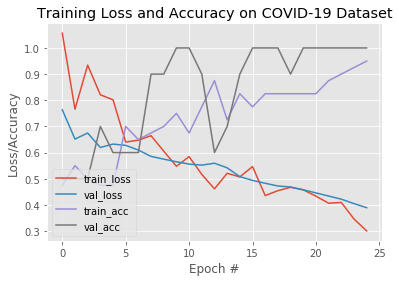

In [11]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy on COVID-19 Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()